# Extract GPS data from dashcam footage
gps_bend_finding_with_gaussian_smoothing_and_DBSCAN_clustering

In [1441]:
ids = [61]

min_string_length = 9
DATASET_PATH = "/home/aap9002/Stereo-Road-Curvature-Dashcam"


In [1442]:
import re
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [1443]:
def count_frames(video_path:str):
    """Count the number of frames in the video

    Args:
        video_path (str): The path to the video

    Returns:
        int: The number of frames in the video
    """
    
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return length

def get_file_and_output_folder(id:int):
    """Get the file path and output folder for the given id

    Args:
        id (int): The id of the video

    Returns:
        tuple[str, str]: The file path and the output_folder
    """
    
    file_path = f"{DATASET_PATH}/day/{id:03d}/R.MP4"
    output_folder = f"{DATASET_PATH}/day/{id:03d}/bends"

    if not os.path.exists(file_path):
        raise FileNotFoundError(f'File {file_path} not found')
    
    print(f'Processing video {id:03d} with {count_frames(file_path)} frames')
    os.makedirs(output_folder, exist_ok=True)
    print(f'Results will be saved in {output_folder}')
    return file_path, output_folder

def time_stamp_to_epoch(time_stamp:str):
    """Convert a time stamp to epoch time

    Args:
        time_stamp (str): The time stamp in the format HHMMSS:sss

    Returns:
        int: The epoch time
    """
    
    hours = int(time_stamp[:2])
    minutes = int(time_stamp[2:4])
    seconds = int(time_stamp[4:6])
    milliseconds = int(time_stamp[7:])

    return (hours*60*60 + minutes*60 + seconds)*1000 + milliseconds

In [1444]:
file_path, output_folder = get_file_and_output_folder(ids[0])

Processing video 061 with 5400 frames
Results will be saved in /home/aap9002/Stereo-Road-Curvature-Dashcam/day/061/bends


In [1445]:
!firefox {file_path} # display the video

Gtk-Message: 06:46:43.711: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
[831078, Main Thread] WARNING: GTK+ module /snap/firefox/5647/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.: 'glib warning', file /build/firefox/parts/firefox/build/toolkit/xre/nsSigHandlers.cpp:201

(firefox:831078): Gtk-WARNING **: 06:46:43.805: GTK+ module /snap/firefox/5647/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 06:46:43.805: Failed to load module "canberra-gtk-module"
[831078, Main Thread] WARNING: GTK+ module /snap/firefox/5647/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same proc

# Read file contents

In [1446]:
def getNMEAStringsFromFile(file_path:str):
    """Get the NMEA strings from the file

    Args:
        file_path (str): The path to the file

    Returns:
        List[str]: The GPRMC|GPGGA strings from the file
    """
    strings = ""
    with open(file_path, "rb") as f:
        strings = f.read()

    pattern =  rb'\$(?:GPRMC|GPGGA)[ -~]{' + str(min_string_length).encode() + rb',}'
    strings = re.findall(pattern, strings)    
    return [s.decode('utf-8', errors='ignore') for s in strings]

In [1447]:
data = getNMEAStringsFromFile(file_path)
frame_count = count_frames(file_path)
print(f'Found {len(data)} strings, of which {frame_count} frames are available')
data[:10]

Found 4022 strings, of which 5400 frames are available


['$GPRMC,125207.700,A,5313.90705,N,00218.04379,W,26.948,235.62,241124,,,A*6A',
 '$GPGGA,125207.700,5313.90705,N,00218.04379,W,1,15,0.73,73.4,M,49.6,M,,*52',
 '$GPRMC,125207.800,A,5313.90662,N,00218.04482,W,27.091,234.25,241124,,,A*68',
 '$GPGGA,125207.800,5313.90662,N,00218.04482,W,1,15,0.73,73.4,M,49.6,M,,*5E',
 '$GPRMC,125207.900,A,5313.90620,N,00218.04585,W,26.914,236.31,241124,,,A*6B',
 '$GPGGA,125207.900,5313.90620,N,00218.04585,W,1,15,0.73,73.5,M,49.6,M,,*5E',
 '$GPRMC,125208.000,A,5313.90579,N,00218.04690,W,27.631,236.54,241124,,,A*6F',
 '$GPGGA,125208.000,5313.90579,N,00218.04690,W,1,15,0.73,73.5,M,49.6,M,,*50',
 '$GPRMC,125208.100,A,5313.90537,N,00218.04797,W,27.739,236.53,241124,,,A*6C',
 '$GPGGA,125208.100,5313.90537,N,00218.04797,W,1,15,0.73,73.5,M,49.6,M,,*5D']

In [1448]:
def knots_to_mph(knots:float):
    """Convert knots to miles per hour

    Args:
        knots (float): The speed in knots

    Returns:
        float: The speed in miles per hour
    """
    return knots * 1.15078

def parse_gprmc(input_sequence:str):
    """Parse the GPRMC string and extract the latitude, longitude and speed

    Args:
        input_sequence (str): The GPRMC string

    Returns:
        dict: The extracted values as a dictionary
    """
    # $GPRMC,<time>,<status>,<latitude>,<N/S>,<longitude>,<E/W>,<speed>,<course>,<date>,<magnetic variation>,<E/W>,<checksum>
    parts = input_sequence.split(',')
    if len(parts) < 10 or parts[0] != '$GPRMC':
        # print(f'Invalid GPRMC string: {input_sequence}')
        return None
    
    # Extract latitude and longitude with direction
    time = parts[1]
    valid = parts[2]  # A - data valid, V - data invalid
    latitude = parts[3]
    lat_direction = parts[4]
    longitude = parts[5]
    lon_direction = parts[6]
    speed = parts[7]  # Speed in knots

    speed = knots_to_mph(float(speed))  # Convert speed to mph
    
    # Return the extracted values as a dictionary
    return {
        "time": time,
        "valid": True if valid == 'A' else False,
        "latitude": latitude + ' ' + lat_direction,
        "longitude": longitude + ' ' + lon_direction,
        "speed": speed
    }

In [1449]:
positions = []
for sentence in data:
    lat_lon = parse_gprmc(sentence)
    if lat_lon:
        positions.append(lat_lon)

print(f"Found {len(positions)} positions")
print("valid positions:", len([p for p in positions if p['valid']]))
print("invalid positions:", len([p for p in positions if not p['valid']]))

STARTING_TIME = time_stamp_to_epoch(positions[0]['time'])
print(f"Starting time: {STARTING_TIME}")

END_TIME = time_stamp_to_epoch(positions[-1]['time'])
print(f"Ending time: {END_TIME}")

# remove records with the same values
positions = [dict(t) for t in {tuple(d.items()) for d in positions}]
print(f"Unique positions: {len(positions)}")



positions[:2]


Found 2011 positions
valid positions: 2011
invalid positions: 0
Starting time: 46327700
Ending time: 46507600
Unique positions: 1828


[{'time': '125356.300',
  'valid': True,
  'latitude': '5313.34119 N',
  'longitude': '00218.85867 W',
  'speed': 46.936863859999995},
 {'time': '125323.900',
  'valid': True,
  'latitude': '5313.52854 N',
  'longitude': '00218.65583 W',
  'speed': 16.93257692}]

## Remove invalid records and records under 15 mph

In [1450]:
def filter_invalid_and_low_mph_records(positions):
    """Filter the data points to remove
        - invalid points
        - points less than 15 mph
        - points with the same latitude and longitude
    
    Args:
        positions (List[dict]): The list of positions
    
    Returns:
        List[dict]: The filtered list of positions
    """
    filtered_positions = []
    for i in range(len(positions)):
        if not positions[i]['valid']:
            continue

        if positions[i]['speed'] < 15:
            continue

        filtered_positions.append(positions[i])
    return filtered_positions

In [1451]:
positions = filter_invalid_and_low_mph_records(positions)

print(f"{len(positions)} positions after filtering")
positions[:2]

1732 positions after filtering


[{'time': '125356.300',
  'valid': True,
  'latitude': '5313.34119 N',
  'longitude': '00218.85867 W',
  'speed': 46.936863859999995},
 {'time': '125323.900',
  'valid': True,
  'latitude': '5313.52854 N',
  'longitude': '00218.65583 W',
  'speed': 16.93257692}]

## Plot on graph

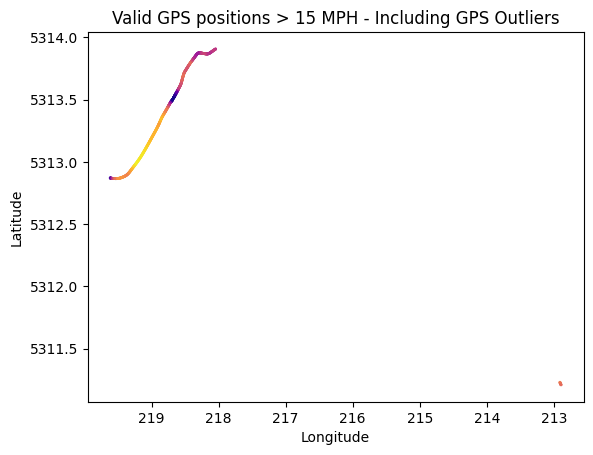

In [1452]:
longitudes = [float(pos['longitude'].split()[0]) for pos in positions]
latitudes = [float(pos['latitude'].split()[0]) for pos in positions]

speeds = [pos['speed'] for pos in positions]

norm = plt.Normalize(min(speeds), max(speeds))
cmap = plt.cm.plasma


plt.scatter(longitudes, latitudes, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# flip axis to show the map in the correct orientation
plt.gca().invert_xaxis()
plt.title('Valid GPS positions > 15 MPH - Including GPS Outliers')
# show heat map of point concentration
plt.show()

# remove outliers

Median Longitude: 218.69187499999998
Median Latitude: 5313.487555


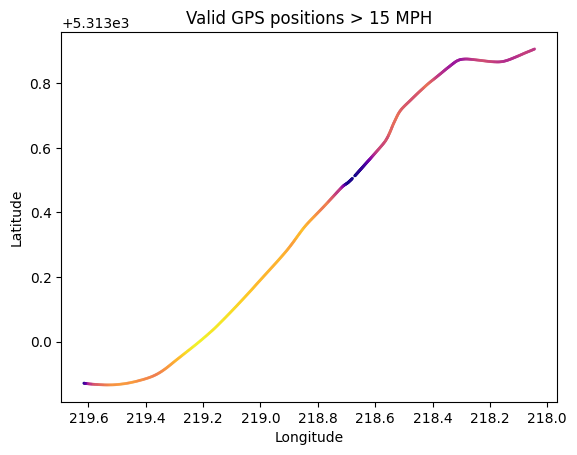

In [1453]:
longitudes = [float(pos['longitude'].split()[0]) for pos in positions]
latitudes = [float(pos['latitude'].split()[0]) for pos in positions]
speeds = [pos['speed'] for pos in positions]

median_longitude = np.median(longitudes)
median_latitude = np.median(latitudes)

print(f'Median Longitude: {median_longitude}')
print(f'Median Latitude: {median_latitude}')

# filter out the points that are not within 0.1 of the median
positions = [pos for pos in positions if abs(float(pos['longitude'].split()[0]) - median_longitude) < 2 and abs(float(pos['latitude'].split()[0]) - median_latitude) < 2]

longitudes = [float(pos['longitude'].split()[0]) for pos in positions]
latitudes = [float(pos['latitude'].split()[0]) for pos in positions]
speeds = [pos['speed'] for pos in positions]


plt.scatter(longitudes, latitudes, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# flip axis to show the map in the correct orientation
plt.gca().invert_xaxis()
plt.title('Valid GPS positions > 15 MPH')
# show heat map of point concentration
plt.show()

# Find bends

In [1454]:
# def find_bends(positions):
#     headings = []

#     for i in range(1, len(positions)):
#         lat1, lon1 = positions[i-1]
#         lat2, lon2 = positions[i]
#         if lat1 == lat2 and lon1 == lon2:
#             continue

#         # Calculate the heading from the first to the second position
#         heading = np.arctan2(lon2 - lon1, lat2 - lat1) * 180 / np.pi
#         headings.append(heading)

#     # Calculate the difference between consecutive headings
#     bends = np.diff(headings)
#     return bends
# average_window = 20

# smooth_latitudes = np.convolve(latitudes, np.ones(average_window)/average_window)
# smooth_longitudes = np.convolve(longitudes, np.ones(average_window)/average_window)

# bends = find_bends(list(zip(smooth_latitudes, smooth_longitudes)))

# smooth_bends = np.convolve(bends, np.ones(average_window)/average_window)


# plt.title('Heading changes by frame')
# plt.xlabel('Frame')
# plt.ylabel('Heading change')
# plt.plot(smooth_bends)

In [1455]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from scipy.ndimage import convolve1d

# plt.title("All angles in GPS Path > 15 MPH")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.gca().invert_xaxis()

# # Step 1: Compute vector differences
# diff_lon = np.diff(longitudes)
# diff_lat = np.diff(latitudes)

# smooth_lon = convolve1d(diff_lon, np.ones(10) / 10)
# smooth_lat = convolve1d(diff_lat, np.ones(10) / 10)

# vectors = np.vstack((smooth_lon, smooth_lat)).T

# # Step 2: Compute angles between consecutive vectors
# angles = []
# forward_window = 5 # consider current vector window head
# backward_window = 5

# # Corrected loop range to ensure valid indices
# for i in range(backward_window, len(vectors) - backward_window - forward_window + 1):
#     # Calculate averaged vectors for previous and next windows
#     v1 = vectors[i - backward_window:i]
#     v2 = vectors[i:i + forward_window]

#     v1_sum = np.sum(v1, axis=0)
#     v2_sum = np.sum(v2, axis=0)
    
#     # Compute angle between vectors
#     cos_theta = np.dot(v1_sum, v2_sum) / (np.linalg.norm(v1_sum) * np.linalg.norm(v2_sum))
#     angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    
#     # Determine direction using cross product
#     cross_product = np.cross(np.append(v1_sum, 0), np.append(v2_sum, 0))[2]
#     if cross_product < 0:
#         angle = -angle
    
#     angles.append(np.degrees(angle))

# print(f"Found {len(angles)} angles")
# print(angles)

# # smooth angles my median filter
# angles = np.convolve(angles, np.ones(5) / 5, mode='same')

# # Detect bends based on angle change threshold
# lower_threshold = 30  # degrees
# angle_diff = np.abs(np.diff(angles))
# bends = np.where(angle_diff > lower_threshold)[0]

# print(f"Found {len(bends)} bends")
# print(angle_diff[:10])
      
# # Group consecutive bend indices and average their positions
# bend_clusters = np.split(bends, np.where(np.diff(bends) != 1)[0] + 1)
# bends = [int(np.mean(cluster)) for cluster in bend_clusters]


# # Correct index mapping to original data points
# bends = [bend + backward_window + forward_window for bend in bends]

# # Plotting (assuming cmap and norm are defined elsewhere)
# for lon, lat, speed in zip(longitudes, latitudes, speeds):
#     plt.scatter(lon, lat, color=cmap(norm(float(speed))), s=1)

# # Plot and annotate bends
# for bend in bends:
#     if bend < len(longitudes):  # Ensure valid index
#         plt.scatter(longitudes[bend], latitudes[bend], color='red', zorder=2)

# plt.savefig(os.path.join(output_folder, "bends.png"))
# plt.show()

In [1456]:
# import numpy as np
# import matplotlib.pyplot as plt

# plt.title("All angles in GPS Path > 15 MPH")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.gca().invert_xaxis()

# ## Step 1: Compute vector differences
# diff_lon = np.diff(longitudes)
# diff_lat = np.diff(latitudes)
# vectors = np.vstack((diff_lon, diff_lat)).T

# # Step 2: Compute angles between consecutive vectors
# angles = []
# forward_window = 30 # consider current vector window head
# backward_window = 30

# for i in range(backward_window , len(vectors) - (forward_window+backward_window) -1):
#     v1 = vectors[i:i + backward_window].mean(axis=0)
#     v2 = vectors[i + backward_window:i + backward_window + forward_window].mean(axis=0)

#     cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
#     angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))

#     # Calculate cross product to determine direction
#     cross_product = np.cross([*v1, 0], [*v2, 0])[2]
#     if cross_product < 0:
#         angle = -angle

#     angles.append(np.degrees(angle))

# # Detect bends based on angle threshold
# lower_threshold = 40  # degrees, for example
# bends = np.where(abs(np.array(angles)) > lower_threshold)[0]

# # ignore last bend due to noisy data
# bends = bends[:-1]

# # Shift bends to account for the forward window
# bends = [bend + backward_window for bend in bends]

# for lon, lat, speed in zip(longitudes, latitudes, speeds):
#     plt.scatter(lon, lat, color=cmap(norm(float(speed))), s=1)
   
# # Plot and annotate bends
# for bend in bends:
#     plt.scatter(longitudes[bend], latitudes[bend], color='red')
#     # direction = "left" if angles[bend] < 0 else "right"
#     # plt.text(longitudes[bend], latitudes[bend], f"{angles[bend]:.1f}° {direction}", color='blue')

# plt.savefig(os.path.join(output_folder, "bends.png"))
# plt.show()


Found 1684 angles
[44.15743558 52.99464612 58.82695023 60.26444386 59.6759595 ]


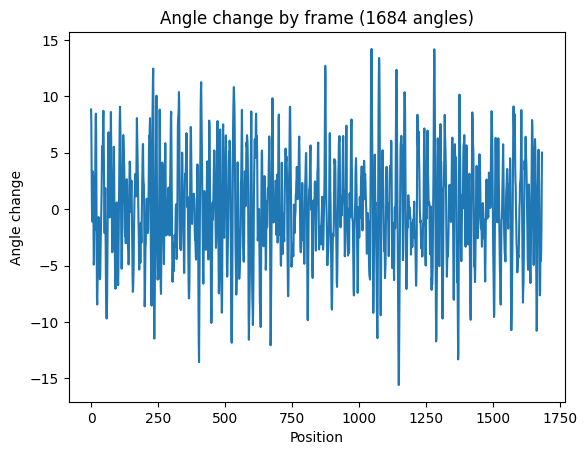

Found 52 bends
[ 11.69466183  12.46042899 -11.48044204  10.05904091  10.38362723
 -12.00793403 -13.56749739 -10.17996154  10.57972964  11.25693601]
Found 3 bends after clustering


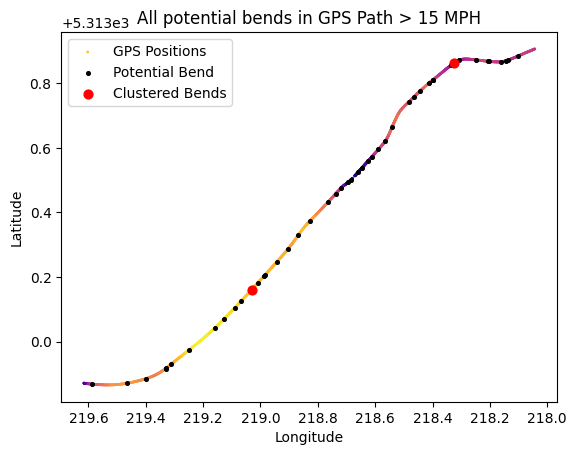

In [1457]:
from cProfile import label
from matplotlib import legend
from numpy import angle
from sklearn.cluster import DBSCAN

diff_lon = np.diff(longitudes)
diff_lat = np.diff(latitudes)
vectors = np.vstack((diff_lon, diff_lat)).T

# find reletive angles between vectors
# angles = []

# for i in range(1, len(vectors)):
#     v1 = vectors[i-1]
#     v2 = vectors[i]

#     cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
#     angle = np.arccos(np.clip(cos_theta, -1.5759, 1.5759))

#     cross_product = np.cross([*v1, 0], [*v2, 0])[2]
#     # if cross_product < 0:
#     #     angle = -angle

#     angles.append(np.degrees(angle))

angles = np.arctan2(diff_lon, diff_lat)

angles = np.arctan2(np.sin(angles), np.cos(angles)) # normalize angles

angles = np.degrees(angles)

# median filter to smooth angles
# temp = angles.copy()
# for i in range(3, len(angles)-3):
#     angles[i] = np.median(temp[i-3:i+4])

# smooth angles with gaussian filter
angles = np.convolve(angles, np.ones(3) / 3, mode='valid')
gaussian_kernel = np.exp(-np.linspace(-1, 1, 10)**2)
# zero first half of the kernel
zero = np.zeros_like(gaussian_kernel)
gaussian_kernel = np.concatenate([zero, gaussian_kernel])
gaussian_kernel /= gaussian_kernel.sum()
angles = np.convolve(angles, gaussian_kernel, mode='valid')

print(f"Found {len(angles)} angles")
print(angles[:5])
angles_derivative = np.gradient(angles)

plot_angles = angles_derivative
plt.title(f"Angle change by frame ({len(angles)} angles)")
plt.xlabel("Position")
plt.ylabel("Angle change")
plt.plot(plot_angles)
plt.show()

# angle change threshold
lower_threshold = 10  # degrees
# angle_diff = np.abs(np.diff(angles))
bends = np.where(np.abs(angles_derivative) > lower_threshold)[0]

print(f"Found {len(bends)} bends")
print(angles_derivative[bends][:10])

# cluster bends
bends_positions = np.array(list(zip(longitudes, latitudes)))[bends]

temp_store_bends = bends_positions.copy()


# bends = cluster.vq.kmeans(bends_positions, )[0]
# Apply DBSCAN clustering (automatic K)
if len(bends_positions) > 1:
    dbscan = DBSCAN(eps=0.015, min_samples=3, metric="euclidean")  # Adjust eps based on your GPS resolution
    labels = dbscan.fit_predict(bends_positions)
    
    # Get unique cluster centers
    unique_labels = set(labels)
    bends = np.array([bends_positions[labels == i].mean(axis=0) for i in unique_labels if i != -1])  # Ignore noise
else:
    bends = bends_positions  # If no clustering is needed, keep original bends

print(f"Found {len(bends)} bends after clustering")

# ignore last bend due to noisy data
bends = bends[:-1]

plt.scatter(
    longitudes,
    latitudes,
    c=[cmap(norm(float(s))) for s in speeds],
    s=1,
    label='GPS Positions'
)

plt.scatter(
    temp_store_bends[:, 0],
    temp_store_bends[:, 1],
    color='black',
    label='Potential Bend',
    s=7
)

if len(bends) > 0:
    plt.scatter(
        bends[:,0],
        bends[:,1],
        color='red',
        label='Clustered Bends',
        s=40
    )
else:
    plt.legend(["GPS Positions", "Potential Bend"])
    
plt.title("All potential bends in GPS Path > 15 MPH")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.gca().invert_xaxis()
# plt.legend(["GPS Positions", "Potential Bend", "Clustered Bends"])
plt.legend()

plt.savefig(os.path.join(output_folder, "bends.png"))
plt.show()

In [1458]:
bends

array([[ 218.32690333, 5313.8626    ],
       [ 219.030665  , 5313.16078   ]])

In [1459]:
cap = cv2.VideoCapture(file_path, cv2.CAP_FFMPEG)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate = cap.get(cv2.CAP_PROP_FPS)

print(f"Total frames: {total_frames}")

print(f"Frame rate: {frame_rate}")

Total frames: 5400
Frame rate: 29.97002997002997


In [1460]:
def time_stamp_to_frame_number(time_stamp):
    diff = time_stamp_to_epoch(time_stamp) - STARTING_TIME
    total_time = END_TIME - STARTING_TIME
    if total_time <= 0:
        return 0
    
    return int((diff / total_time) * total_frames)

def get_closest_position_based_on_lat_lon(lat, lon):
    min_distance = float('inf')
    closest_position = None
    for position in positions:
        p_lat = float(position['latitude'].split()[0])
        p_lon = float(position['longitude'].split()[0])
        distance = (p_lat - lat)**2 + (p_lon - lon)**2
        if distance < min_distance:
            min_distance = distance
            closest_position = position
    return closest_position


def get_frame_number_based_on_bend_long_lat(bends):
    frame_numbers = []
    for bend in bends:
        closest_position = get_closest_position_based_on_lat_lon(bend[1], bend[0])
        frame_number = time_stamp_to_frame_number(closest_position['time'])
        # print(f"frame_number: {frame_number}")
        frame_numbers.append(frame_number)

    return frame_numbers

frame_numbers = get_frame_number_based_on_bend_long_lat(bends)

# frame_numbers = [int(frame_number*(frame_rate/10)) for frame_number in frame_numbers]

frame_numbers

[741, 3827]

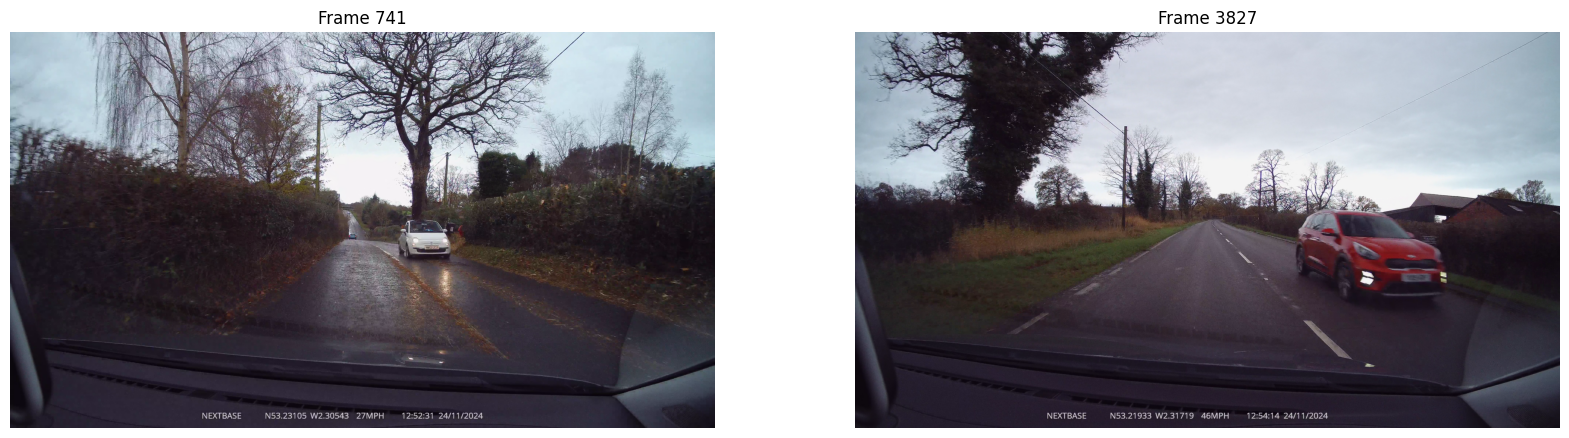

Total frames: 5400


In [1461]:
frames = []

frame_numbers = sorted(frame_numbers)

for frame_number in frame_numbers:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        frames.append(frame)
    else:
        print(f"Warning: Could not read frame {frame_number}")
 
cap.release()

if frames:
    fig, axes = plt.subplots(1, len(frames), figsize=(20, 10))
    if len(frames) == 1:
        axes.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
        axes.axis('off')
        axes.set_title(f"Frame {frame_numbers[0]}")
    else:
        for i, frame in enumerate(frames):
            axes[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axes[i].axis('off')
            axes[i].set_title(f"Frame {frame_numbers[i]}")
    plt.show()
else:
    print("No frames to display")

print(f"Total frames: {total_frames}")

In [1462]:
for i, frame in enumerate(frames):
    output_file = os.path.join(output_folder, f"bend_{i}.jpg")
    cv2.imwrite(output_file, frame)
